# Lens modeling of DESIJ2158+0257 with `lenstronomy`

**Author:** Fahim Rajit Hossain, Anowar Shajib, Mir Sazzat Hossain  

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import of standard python libraries
import numpy as np
!pip install corner
import corner
import matplotlib.pyplot as plt

%matplotlib inline
!pip install emcee
import emcee
import h5py
import joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.4 MB/s eta 0:00:00


In [ ]:
# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.8 MB/s eta 0:00:00
  Created wheel for lenstronomy: filename=lenstronomy-1.11.2-py3-none-any.whl size=1086826 sha256=e92d4ed31e0a550da480145bd7f5f9c8adf3b76308c230ba521774a41336cac0
  Stored in directory: /root/.cache/pip/wheels/1c/62/fa/1c6f5bd9f9e9e37978c5ef811810e69118ea87f2a1cd0b946d
  Created wheel for schwimmbad: filename=schwimmbad-0.3.2-py3-none-any.whl size=15728 sha256=67db972b7a1507f726052b6dd30307b7fa2da89f3

## Load imaging data

The data and the PSF needs to be provided to `lenstronomy` using the
dictionaries `kwargs_data` and `kwargs_psf`.

In `kwargs_data`, we also need to proivde information on the noise level.
Either the pixel-wise noise map can be provided using the `noise_map`
keyword, or simply the `exposure_time` and `background_rms` can be provided
for `lenstronomy` to create the noise map by itself.

In [ ]:
# load HDF5 file

with h5py.File('/content/DESIJ2158+0257_F140W.h5', 'r') as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]
        
kwargs_data

# load HDF5 psf file using h5py
with h5py.File('/content/psf_F140W.h5', 'r') as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
        
kwargs_psf['psf_type'] = 'PIXEL'
kwargs_psf

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
         3.2385867e-06, 4.4331632e-06],
        [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
         6.6143798e-06, 4.1430776e-06],
        [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
         5.1404800e-06, 1.7530243e-06],
        ...,
        [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
         5.3933368e-06, 1.6360833e-06],
        [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
         8.7221979e-06, 3.7005334e-06],
        [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
         3.2246478e-06, 5.1252514e-06]], dtype=float32),
 'psf_type': 'PIXEL'}

In [ ]:
image_size = kwargs_data['image_data'].shape
print(image_size)

(220, 220)


<ipython-input-6-5a1f5d1a8588>:1: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kwargs_data['image_data']), origin='lower',


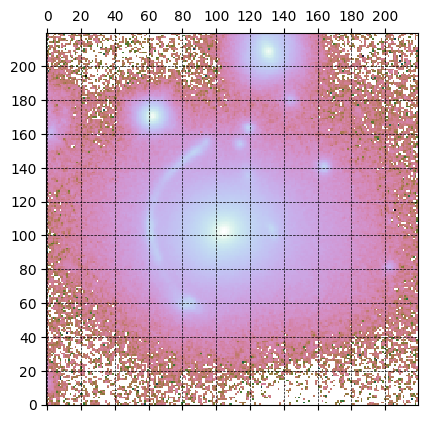

In [ ]:
plt.matshow(np.log10(kwargs_data['image_data']), origin='lower', 
            cmap='cubehelix')
plt.grid(True, which='both', linewidth=0.5, linestyle = '--', color='black')

plt.xticks(np.arange(0, 220, 20))
plt.yticks(np.arange(0, 220, 20))

plt.show()

# Creating Likelihood Mask

A likelihood mask is a tool used in statistical analysis, particularly in Bayesian statistics, to identify data points that have a strong influence on the final results of a model. It is a binary mask that identifies which data points in the model contribute to the likelihood function, and which data points do not.

In practical terms, a likelihood mask can be created by setting a threshold for the quality of the data, such as the signal-to-noise ratio or the uncertainty in the measurements. Data points that do not meet this threshold can be masked out, effectively removing them from the analysis. This can help to improve the accuracy and precision of the model by reducing the impact of noisy or unreliable data.

Likelihood masks can also be used to exclude regions of the data that are known to be problematic, such as areas affected by foreground contamination, instrumental effects, or other sources of systematic error. By excluding these regions from the analysis, the likelihood mask can help to improve the robustness and reliability of the model.

In [ ]:
from lenstronomy.Util import mask_util
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util import util

    
ra_at_xy_0 = kwargs_data['ra_at_xy_0']
dec_at_xy_0 = kwargs_data['dec_at_xy_0']
transform_pix2angle = kwargs_data['transform_pix2angle']

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data['image_data'])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r = 8.5   # arcsecond
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(lens_center_ra,
                                      lens_center_dec,
                                      r,
                                      util.image2array(x_coords),
                                      util.image2array(y_coords))
        


mask_ext_1 = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra+3.8,
                                   lens_center_dec+4.75,
                                   1.7, 1.7, 0)

mask_ext_2 = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra-1.9,
                                   lens_center_dec+8.,
                                   2.8, 2.8, 0)

mask_ext_3 = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra-2.55,
                                   lens_center_dec+5.2,
                                   .6, .6, 0)

mask_ext_4 = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra-4.3,
                                   lens_center_dec+2.4,
                                   .8, .9, 0)

mask_ext_5 = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra-7.5,
                                   lens_center_dec-2.5,
                                   .6, .6, 0)

mask_ext_6 = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra-0.5,
                                   lens_center_dec+4,
                                   .8, 1, 0)


mask_ext_7 = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra-0.5,
                                   lens_center_dec+1.9,
                                   .8, .9, 0)

mask_ext_8 = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra-4.3,
                                   lens_center_dec-3,
                                   1.5, 2.2, np.pi/12)

mask_ext_9 = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra+0.5,
                                   lens_center_dec-0.8,
                                   0.25, 0.25,0)

'''
mask_ext_8 = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra+2.2,
                                   lens_center_dec-3.9,
                                   1.3, 1.1, np.pi/6)

mask_ext_9 = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra-1.8,
                                   lens_center_dec-0.5,
                                   .7, .7, 0)
'''
mask = (1 - mask_outer)*(1 - mask_ext_1)*(1 - mask_ext_2)*\
      (1 - mask_ext_3)*(1 - mask_ext_4)* (1 - mask_ext_5)*\
      (1 - mask_ext_6)*(1 - mask_ext_7)* (1 - mask_ext_8)*\
        (1 - mask_ext_9)
mask[mask < 0] = 0
        

mask_img_1 = mask.reshape(num_pix, num_pix)

# Applying the Mask

<ipython-input-8-14073cec0ced>:3: RuntimeWarning: invalid value encountered in log10
  ax1.matshow(np.log10(kwargs_data['image_data']),
<ipython-input-8-14073cec0ced>:16: RuntimeWarning: divide by zero encountered in log10
  image1 = np.log10(kwargs_data["image_data"] * mask_img_1)
<ipython-input-8-14073cec0ced>:16: RuntimeWarning: invalid value encountered in log10
  image1 = np.log10(kwargs_data["image_data"] * mask_img_1)


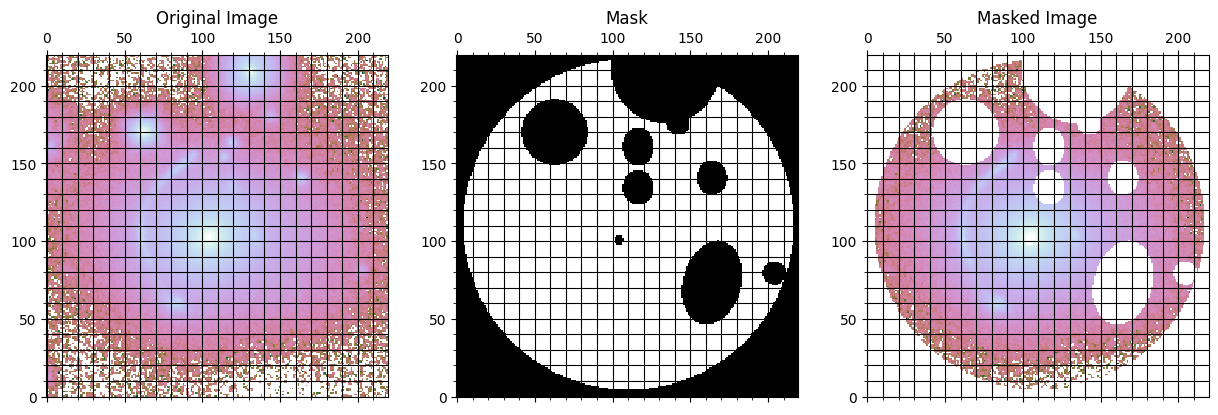

In [ ]:
# plot image and masked image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.matshow(np.log10(kwargs_data['image_data']), 
            origin='lower', cmap='cubehelix')
ax1.grid(which='both', color='black')
ax1.minorticks_on()
ax1.grid(which='minor', color='black')
ax1.title.set_text('Original Image')
ax2.matshow(mask_img_1, origin='lower', cmap='cubehelix')
ax2.grid(which='both', color='black')
ax2.minorticks_on()
ax2.grid(which='minor', color='black')
ax2.title.set_text('Mask')
ax2.title.set_text('Mask')

image1 = np.log10(kwargs_data["image_data"] * mask_img_1)

ax3.matshow(image1, origin='lower', cmap='cubehelix')
ax3.grid(which='both', color='black')
ax3.minorticks_on()
ax3.grid(which='minor', color='black')
ax3.title.set_text('Masked Image')
plt.show()

## Building a lens model

Here, we build a lens model. The lens model can be thought of three
components: the lens galaxy's mass model, the lens galaxy's light model, and
the source galaxy's light model. We have to give a list of profiles for each
 component as shown in the next codecell.

The `'EPL'` lens mass profile stands for Elliptical Power Law. The form of
this convergence profile is given by:
$$\kappa(x, y) = \frac{3 - \gamma}{2} \left[ \frac{\theta_{\rm E}}{\sqrt{q
x^2 + y^2 / q}} \right]^{\gamma - 1}. $$

The position angle $\phi$ adjusts the orientation of the mass profile's
major axis. The ellipticity parameters $q$ and $\phi$ can be reformulated as
$$e_1 = \frac{1 - q}{1 + q} \cos 2\phi,$$
$$e_2 = \frac{1 - q}{1 + q} \sin 2\phi.$$

`lenstronomy` uses $e_1$ and $e_2$ instead of $q$ and $\phi$, because $e_1$
and $e_2$ are easier to handle in numerical optimization, for example, in
MCMC. We checked [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/GettingStarted/units_coordinates_parameters_definitions.ipynb) for more details on
parameter definitions and conventions used in `lenstronomy`.


Both the lens galaxy's and the source galaxy's light profiles are modeled
with Sersic function, which is given by:

$$I(x, y) = I_{\rm e} \exp \left[ -b_{n} \left\{ \left( \frac{\sqrt{qx^2
+ y^2/q}}{R_{\rm Sersic}} \right)^{1/n_{\rm Sersic}} - 1 \right\}
\right].$$

In [ ]:
lens_model_list = ['EPL', 'SHEAR']
source_model_list = ['SERSIC_ELLIPSE', 'SHAPELETS']
# source_model_list = ['SHAPELETS_POLAR_EXP']
lens_light_model_list = ['SERSIC_ELLIPSE','SERSIC_ELLIPSE']

## Lens galaxy's mass model

In [ ]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []


# 'EPL'
fixed_lens.append({})
kwargs_lens_init.append({'theta_E': 3.32635, 'gamma': 1.81094, 'e1':  0.11371, 
                         'e2': -0.07394,'center_x': 0.54844, 
                         'center_y': -0.5563})
kwargs_lens_sigma.append({'theta_E': .3, 'gamma': .1, 'e1': 0.05, 'e2': 0.05,
                         'center_x': 0.5, 'center_y': 0.5})
kwargs_lower_lens.append({'theta_E': 0.01, 'gamma': 1., 'e1': -0.5,
                          'e2': -0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10., 'gamma': 3., 'e1': 0.5, 'e2': 0.5,
                          'center_x': 10, 'center_y': 10})

# add external SHEAR
fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': -0.06649, 'gamma2': -0.05568})
kwargs_lens_sigma.append({'gamma1': 0.05, 'gamma2': 0.05})
kwargs_lower_lens.append({'gamma1': -0.3, 'gamma2': -0.3})
kwargs_upper_lens.append({'gamma1': 0.3, 'gamma2': 0.3})


lens_params = [kwargs_lens_init, 
               kwargs_lens_sigma, 
               fixed_lens, 
               kwargs_lower_lens, 
               kwargs_upper_lens]


## Lens galaxy's light model

In [ ]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []


# First Sersic profile
fixed_lens_light.append({'n_sersic': 1.0})  # SERSIC_ELLIPSE

kwargs_lens_light_init.append({'R_sersic': 3.10360, 'n_sersic': 1, 
                               'e1': 0.29018, 
                               'e2':  0.08729, 'center_x': 0.4589,
                               'center_y': -0.64499, 'amp': 16})
kwargs_lens_light_sigma.append({'n_sersic': 1, 'R_sersic': 0.3, 'e1': 0.05, 
                                'e2': 0.05, 'center_x': 0.1, 'center_y': 0.1, 
                                'amp': 10})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 
                                'n_sersic': .5, 'center_x': -10, 
                                'center_y': -10, 'amp': 0})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 9, 
                                'n_sersic': 1., 
                                'center_x': 10, 'center_y': 10, 'amp': 100})

# Second Sersic profile
fixed_lens_light.append({'n_sersic': 4.0})   # SERSIC_ELLIPSE
kwargs_lens_light_init.append({'R_sersic': 1.24007, 'n_sersic': 4, 
                               'e1': 0.04798,
                               'e2': -0.062085, 'center_x': 0.45891, 
                               'center_y':-0.64499, 'amp': 16})
kwargs_lens_light_sigma.append({'n_sersic': 1, 'R_sersic': 0.3, 'e1': 0.05, 
                                'e2': 0.05, 'center_x': 0.1, 'center_y': 0.1, 
                                'amp': 10})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 
                                'n_sersic': 4., 'center_x': -10, 
                                'center_y': -10, 'amp': 0})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 
                                'n_sersic': 4., 
                                'center_x': 10, 'center_y': 10, 'amp': 100})

# Join centroids of the two Sersic profiles
# joint_lens_with_light = [[0, 0, ['center_x', 'center_y', 'e1', 'e2']]]
joint_lens_light_with_lens_light = [[0, 1, ['center_x', 'center_y']]]


lens_light_params = [kwargs_lens_light_init, 
                     kwargs_lens_light_sigma, 
                     fixed_lens_light, 
                     kwargs_lower_lens_light, 
                     kwargs_upper_lens_light]



## Source galaxy's light model

In [ ]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


# source galaxy's light model

fixed_source.append({'n_sersic': 1.})
kwargs_source_init = [{'n_sersic': 1, 'R_sersic': 0.3190, 'e1': -0.18573, 
                       'e2': 0.01174, 'center_x': 0.97804, 
                       'center_y': -0.37836,'amp': 16}]
kwargs_source_sigma = [{'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.05, 
                        'e2': 0.05, 'center_x': 0.2, 'center_y': 0.2,
                        'amp': 10}]
kwargs_lower_source = [{'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 
                        'n_sersic': .5, 'center_x': -10, 
                        'center_y': -10,'amp': 0}]
kwargs_upper_source = [{'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 
                        'n_sersic': 5., 'center_x': 10,
                        'center_y': 10,'amp': 100}]

# SHAPELETS profile
fixed_source.append({'n_max': 10}) # beta/50 for `SHAPLETS_POLAR_EXP`
kwargs_source_init.append({'beta': 0.07730, 'center_x': 0.97804,
                           'center_y': -0.38637, 'n_max': 10})
kwargs_source_sigma.append({'beta': 0.5, 'center_x': 0.2, 'center_y': 0.2,
                            'n_max': 10})
kwargs_lower_source.append({'beta': 0.01, 'center_x': -10, 'center_y': -10,
                            'n_max': 10 })
kwargs_upper_source.append({'beta': 50, 'center_x': 10, 'center_y': 10,
                            'n_max': 10})

joint_source_with_source = [[0, 1, ['center_x',  'center_y']]]

source_params = [kwargs_source_init, 
                 kwargs_source_sigma, 
                 fixed_source, 
                 kwargs_lower_source, 
                 kwargs_upper_source]


## combining all the above specification in the `kwargs_params` dictionary

In [ ]:
kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params,
                 'lens_light_model': lens_light_params}

kwargs_constraints = {
    'joint_source_with_source': joint_source_with_source,
    'joint_lens_light_with_lens_light': joint_lens_light_with_lens_light,
    # 'joint_lens_with_light': joint_lens_with_light,
}

#### Numerical settings

Applied Mask Likelihood here

In [ ]:
kwargs_likelihood = {'check_bounds': True, 
                     'image_likelihood_mask_list': [mask_img_1]}

kwargs_numerics = {'supersampling_factor': 1,
                   'supersampling_convolution': False
                   }

#### Combining all the information to be sent to lenstronomy

In [ ]:
kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {'multi_band_list': multi_band_list,
                     'multi_band_type': 'single-band'
                     # 'multi-linear': every imaging band has independent 
                     # solutions of the surface brightness, 
                     # 'joint-linear': there is one joint solution of the 
                     # linear coefficients demanded across the bands.
                    }

## Here the model fiting is done


In [ ]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, 
                              kwargs_constraints, 
                              kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 500,
                                'n_iterations': 100, 'threadCount': 3}]]
        

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.9815240705256104 reduced X^2 of best position
-14175.170626530866 log likelihood
28884 effective number of data points
[{'theta_E': 3.333616192318928, 'gamma': 1.8400230641730606, 'e1': 0.11202911990564375, 'e2': -0.07555781297355851, 'center_x': 0.558208592577194, 'center_y': -0.5541948734592259}, {'gamma1': -0.07380541562447604, 'gamma2': -0.056295390679138586, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.2868536588446557, 'n_sersic': 1.0, 'e1': -0.24718087268470054, 'e2': -0.003965794241555956, 'center_x': 1.0139202006958437, 'center_y': -0.4365641537030983}, {'amp': 1, 'n_max': 10, 'beta': 0.07969406704842917, 'center_x': 1.0139202006958437, 'center_y': -0.4365641537030983}] source result
[{'amp': 1, 'R_sersic': 3.0781594084334865, 'n_sersic': 1.0, 'e1': 0.22408135845782978, 'e2': 0.04763123952921467, 'center_x': 0.45482587720490064, 'center_y': -0.6510337510542216}, {'amp': 1,

## Visualizing the fitted model with `PSO`

-0.9784414579757973 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9784414579757971


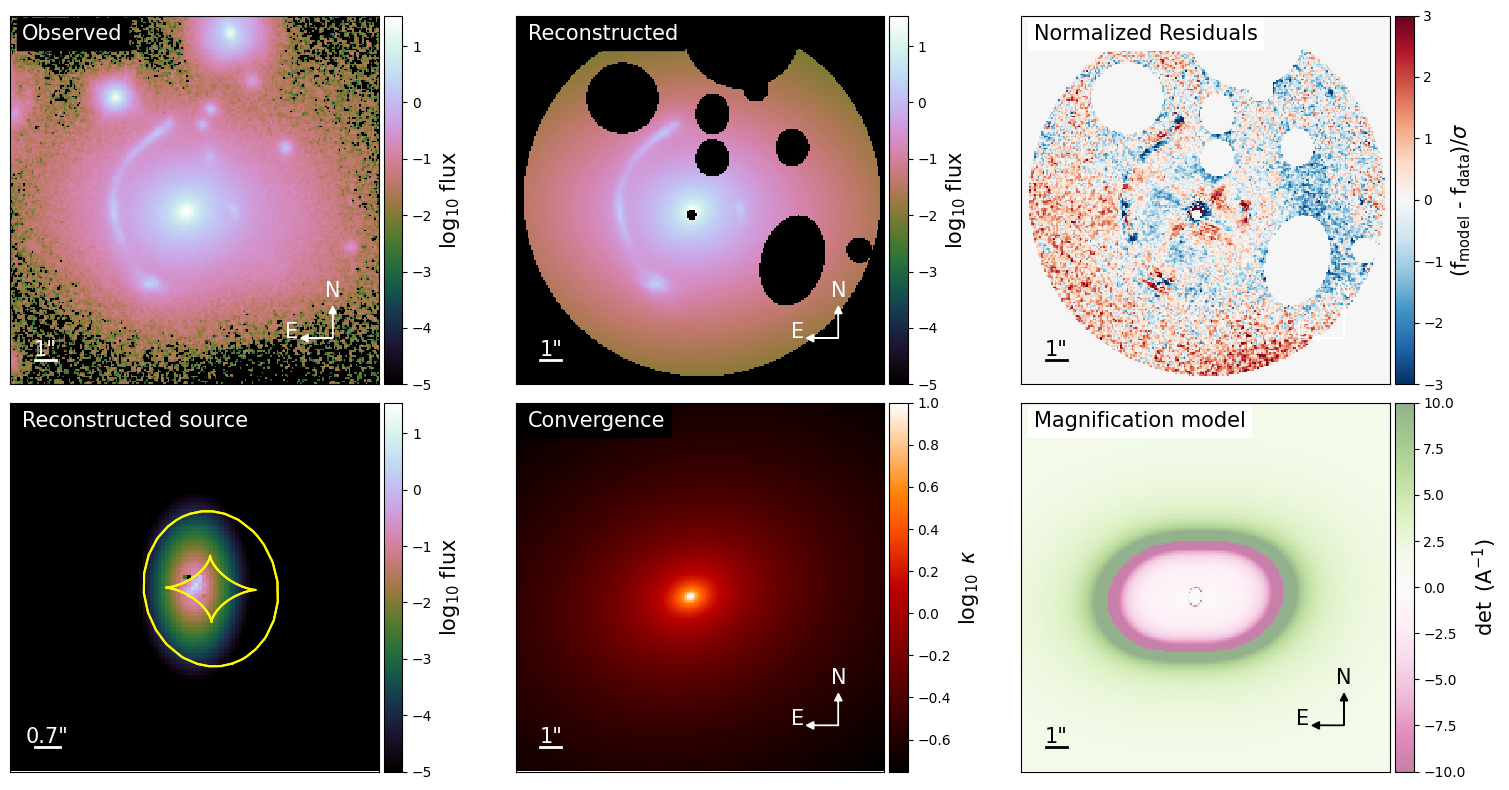

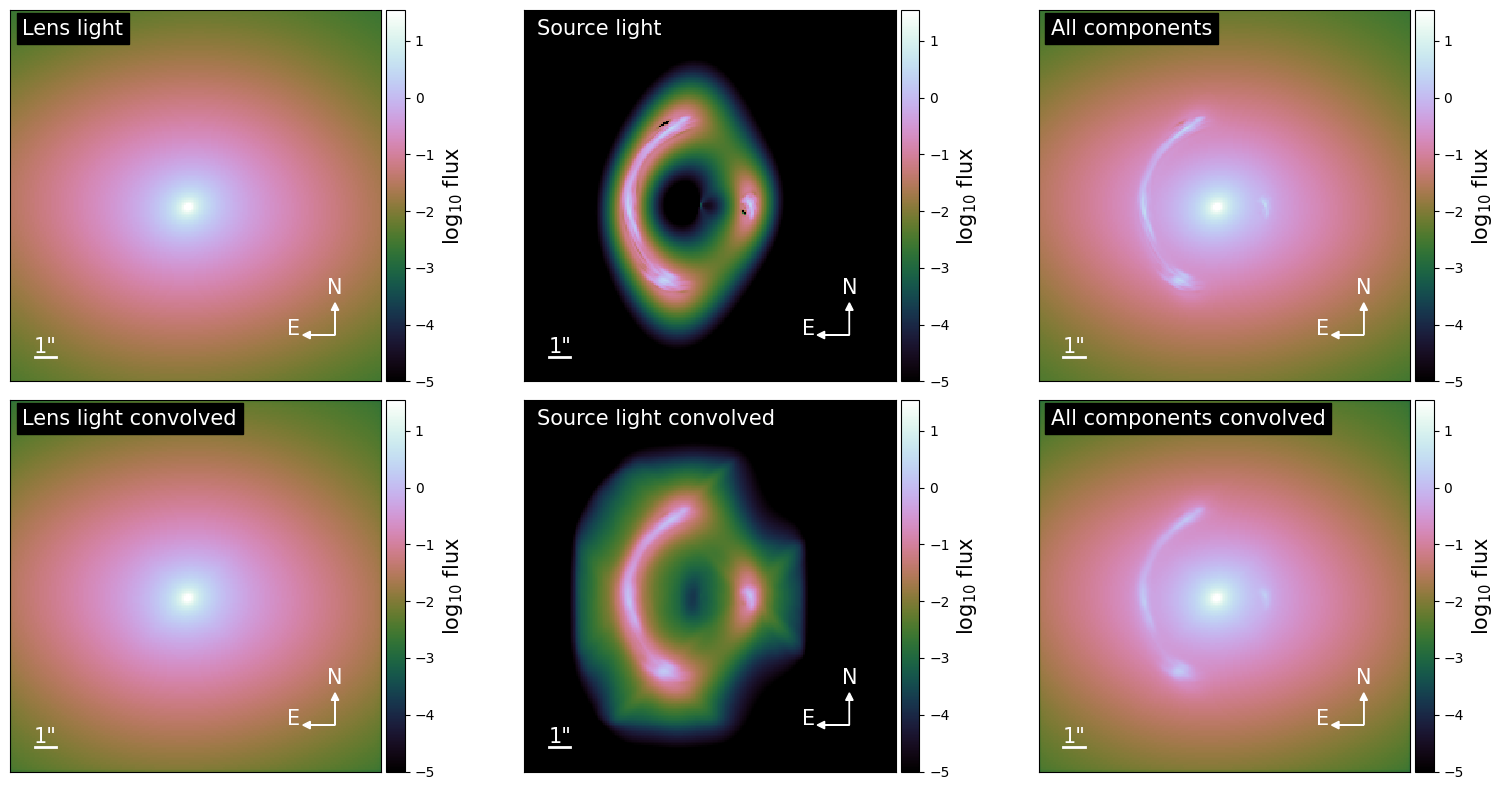

{'kwargs_lens': [{'theta_E': 3.333616192318928, 'gamma': 1.8400230641730606, 'e1': 0.11202911990564375, 'e2': -0.07555781297355851, 'center_x': 0.558208592577194, 'center_y': -0.5541948734592259}, {'gamma1': -0.07380541562447604, 'gamma2': -0.056295390679138586, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.2868536588446557, 'n_sersic': 1.0, 'e1': -0.24718087268470054, 'e2': -0.003965794241555956, 'center_x': 1.0139202006958437, 'center_y': -0.4365641537030983}, {'amp': 1, 'n_max': 10, 'beta': 0.07969406704842917, 'center_x': 1.0139202006958437, 'center_y': -0.4365641537030983}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 3.0781594084334865, 'n_sersic': 1.0, 'e1': 0.22408135845782978, 'e2': 0.04763123952921467, 'center_x': 0.45482587720490064, 'center_y': -0.6510337510542216}, {'amp': 1, 'R_sersic': 0.9185931363876052, 'n_sersic': 4.0, 'e1': 0.042453030632604576, 'e2': -0.06323242437641441, 'center_x': 0.45482587720490064, 'center_y': -0.6510337510542216}], 'kwa

In [ ]:
from lenstronomy.Plots.model_plot import ModelPlot

model_plot = ModelPlot(
    multi_band_list, kwargs_model, kwargs_result, 
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"]
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3,
                                   cmap='RdBu_r')
model_plot.source_plot(ax=axes[1, 0], deltaPix_source=0.1, numPix=100, 
                       with_caustics=True, scale_size=0.7)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap='gist_heat')
model_plot.magnification_plot(ax=axes[1, 2], cmap='PiYG')

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, 
                  top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(ax=axes[0, 0], text='Lens light', 
                              lens_light_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1, 0], text='Lens light convolved', 
                              lens_light_add=True)
model_plot.decomposition_plot(ax=axes[0, 1], text='Source light', 
                              source_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1, 1], text='Source light convolved', 
                              source_add=True)
model_plot.decomposition_plot(ax=axes[0, 2], text='All components', 
                              source_add=True, lens_light_add=True, 
                              unconvolved=True)
model_plot.decomposition_plot(ax=axes[1, 2], text='All components convolved', 
                              source_add=True, lens_light_add=True, 
                              point_source_add=True)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, 
                  wspace=0., hspace=0.05)
plt.show()

print(kwargs_result)

In [ ]:
import joblib

multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed()

init_samples = None  # can be not `None` for MCMC

input = [fitting_kwargs_list, multi_band_list, kwargs_model, 
         kwargs_constraints,
              kwargs_likelihood, kwargs_params, init_samples]
output = [kwargs_result, multi_band_list_out, chain_list, 
          kwargs_fixed_out]

output_path = './DESIJ2158+0257_pso_output.joblib'

with open(output_path, 'wb') as f:
    joblib.dump([input, output], f, compress=True)

## *Separate block for running MCMC*

In [ ]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence

from google.colab import files

# Define the path to the file on Google Drive
mcmc_backend = '/content/drive/MyDrive/BDLensing/mcmc_backend.h5'


fitting_kwargs_list_mcmc = [['MCMC', {'n_burn': 0, 'n_run': 10, 
                                      'n_walkers': 80,
                                      'sigma_scale': .1, 'threadCount': 3,
                                      'backend_filename': mcmc_backend,
                                      'start_from_backend': True}]]

fitting_seq_mcmc = FittingSequence(kwargs_data_joint, kwargs_model,
                                   kwargs_constraints,
                                   kwargs_likelihood, kwargs_params)

chain_list_mcmc = fitting_seq_mcmc.fit_sequence(fitting_kwargs_list_mcmc)
kwargs_result_mcmc = fitting_seq_mcmc.best_fit()


100%|██████████| 10/10 [05:39<00:00, 33.93s/it]

Computing the MCMC...
Number of walkers =  80
Burn-in iterations:  0
Sampling iterations (in current run): 10
342.0495672225952 time taken for MCMC sampling


In [ ]:
if len(chain_list_mcmc) > 0:
    for i, chain in enumerate(chain_list_mcmc):
        print(f"Chain {i + 1}:")
        print("Sampler type:", chain[0])
        print("Parameter names:", chain[2])
        print("Shape of samples:", chain[1].shape)
        print("")

    # Alternatively, you can access the last chain directly
    last_chain = chain_list_mcmc[-1]
    last_samples = last_chain[1]
    last_param_names = last_chain[2]
    print("Last Chain:")
    print("Sampler type:", last_chain[0])
    print("Parameter names:", last_param_names)
    print("Shape of samples:", last_samples.shape)
else:
    print("No MCMC chains available.")


Chain 1:
Sampler type: EMCEE
Parameter names: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'e1_lens_light1', 'e2_lens_light1']
Shape of samples: (231200, 22)

Last Chain:
Sampler type: EMCEE
Parameter names: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'e1_lens_light1', 'e2_lens_light1']
Shape o

## Visualizing the MCMC chain

<ipython-input-20-31513b3d9f3f>:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


N_step: 2890, N_walkers: 80, N_params: 22
theta_E_lens0 3.3226 ± 0.0035
gamma_lens0 1.9326 ± 0.0298
e1_lens0 0.1136 ± 0.0026
e2_lens0 -0.0790 ± 0.0017
center_x_lens0 0.5724 ± 0.0052
center_y_lens0 -0.5574 ± 0.0018
gamma1_lens1 -0.0926 ± 0.0061
gamma2_lens1 -0.0557 ± 0.0008
R_sersic_source_light0 0.3924 ± 0.0181
e1_source_light0 -0.2147 ± 0.0173
e2_source_light0 0.0277 ± 0.0158
center_x_source_light0 1.0864 ± 0.0212
center_y_source_light0 -0.3599 ± 0.0095
beta_source_light1 0.0852 ± 0.0033
R_sersic_lens_light0 3.0724 ± 0.0079
e1_lens_light0 0.2271 ± 0.0024
e2_lens_light0 0.0481 ± 0.0015
center_x_lens_light0 0.4548 ± 0.0004
center_y_lens_light0 -0.6509 ± 0.0003
R_sersic_lens_light1 0.9218 ± 0.0058
e1_lens_light1 0.0428 ± 0.0010
e2_lens_light1 -0.0640 ± 0.0008


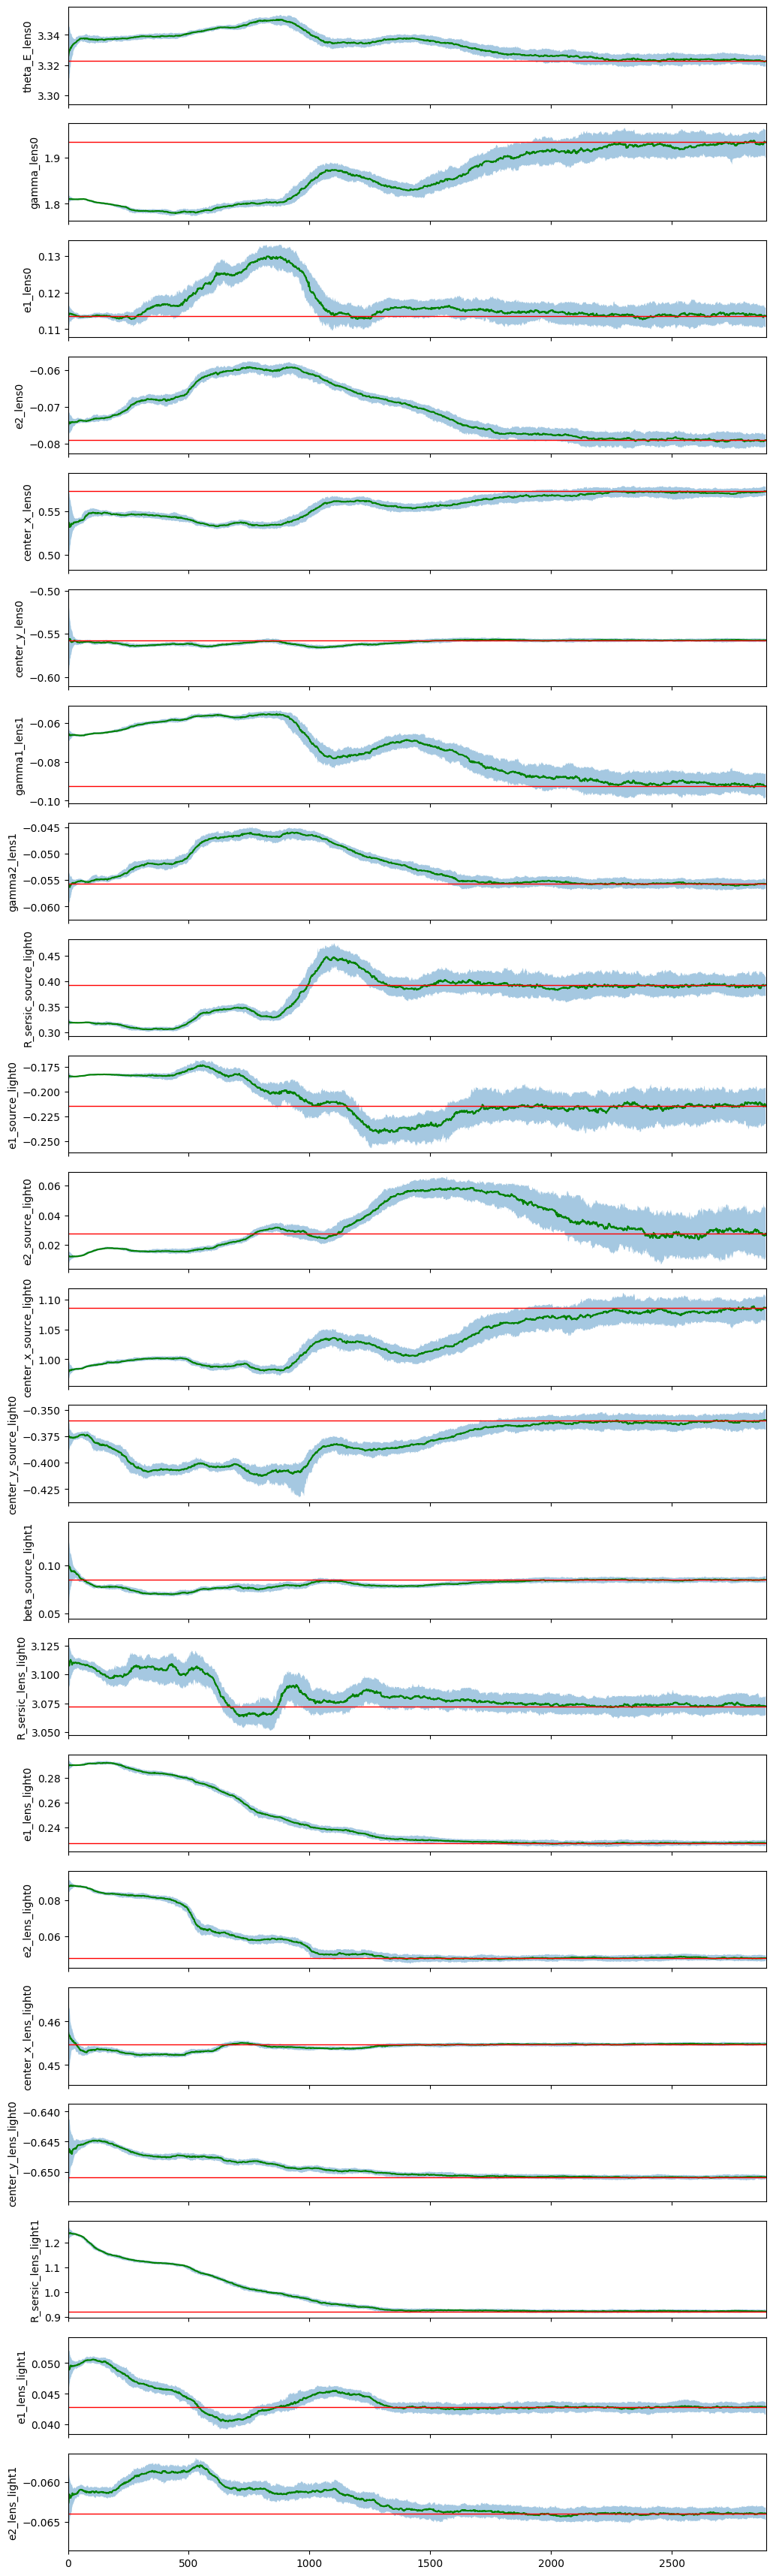

In [ ]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != 'PSO':
# if MCMC chain was broken in the chunks, 
# we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        samples_mcmc = chain_list_mcmc[k][1]

        param_mcmc = chain_list_mcmc[k][2]

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]

    n_walkers = 80  # Adjust the walker ratio as needed
    n_step = 2890 # 10+10+800+400+280+300+200+500+300+50+10+10+10+10

    print('N_step: {}, N_walkers: {}, N_params: {}'.format(n_step, n_walkers, 
                                                           n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order='F')
        chain[:, :, i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [median_pos[0][last - 1], 
     (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
                    median_pos[1][last - 1], 
                     (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2]

    for i in range(n_params):
        print(param_mcmc[i], '{:.4f} ± {:.4f}'.format(median_pos[i][last - 1], 
         (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2))

        ax[i].plot(median_pos[i][:last], c='g')
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c='r', lw=1)
        ax[i].fill_between(np.arange(last), 
                           q84_pos[i][:last], q16_pos[i][:last], alpha=0.4)
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12., 2 * len(param_mcmc)))
        plt.show()


Number of non-linear parameters in the MCMC process: 22
Parameters in order: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'e1_lens_light1', 'e2_lens_light1']
Number of evaluations in the MCMC process: 231200
231200
Shape of samples_mcmc_cut: (1760, 22)


<ipython-input-21-f90d65c68d33>:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc_cut == []:


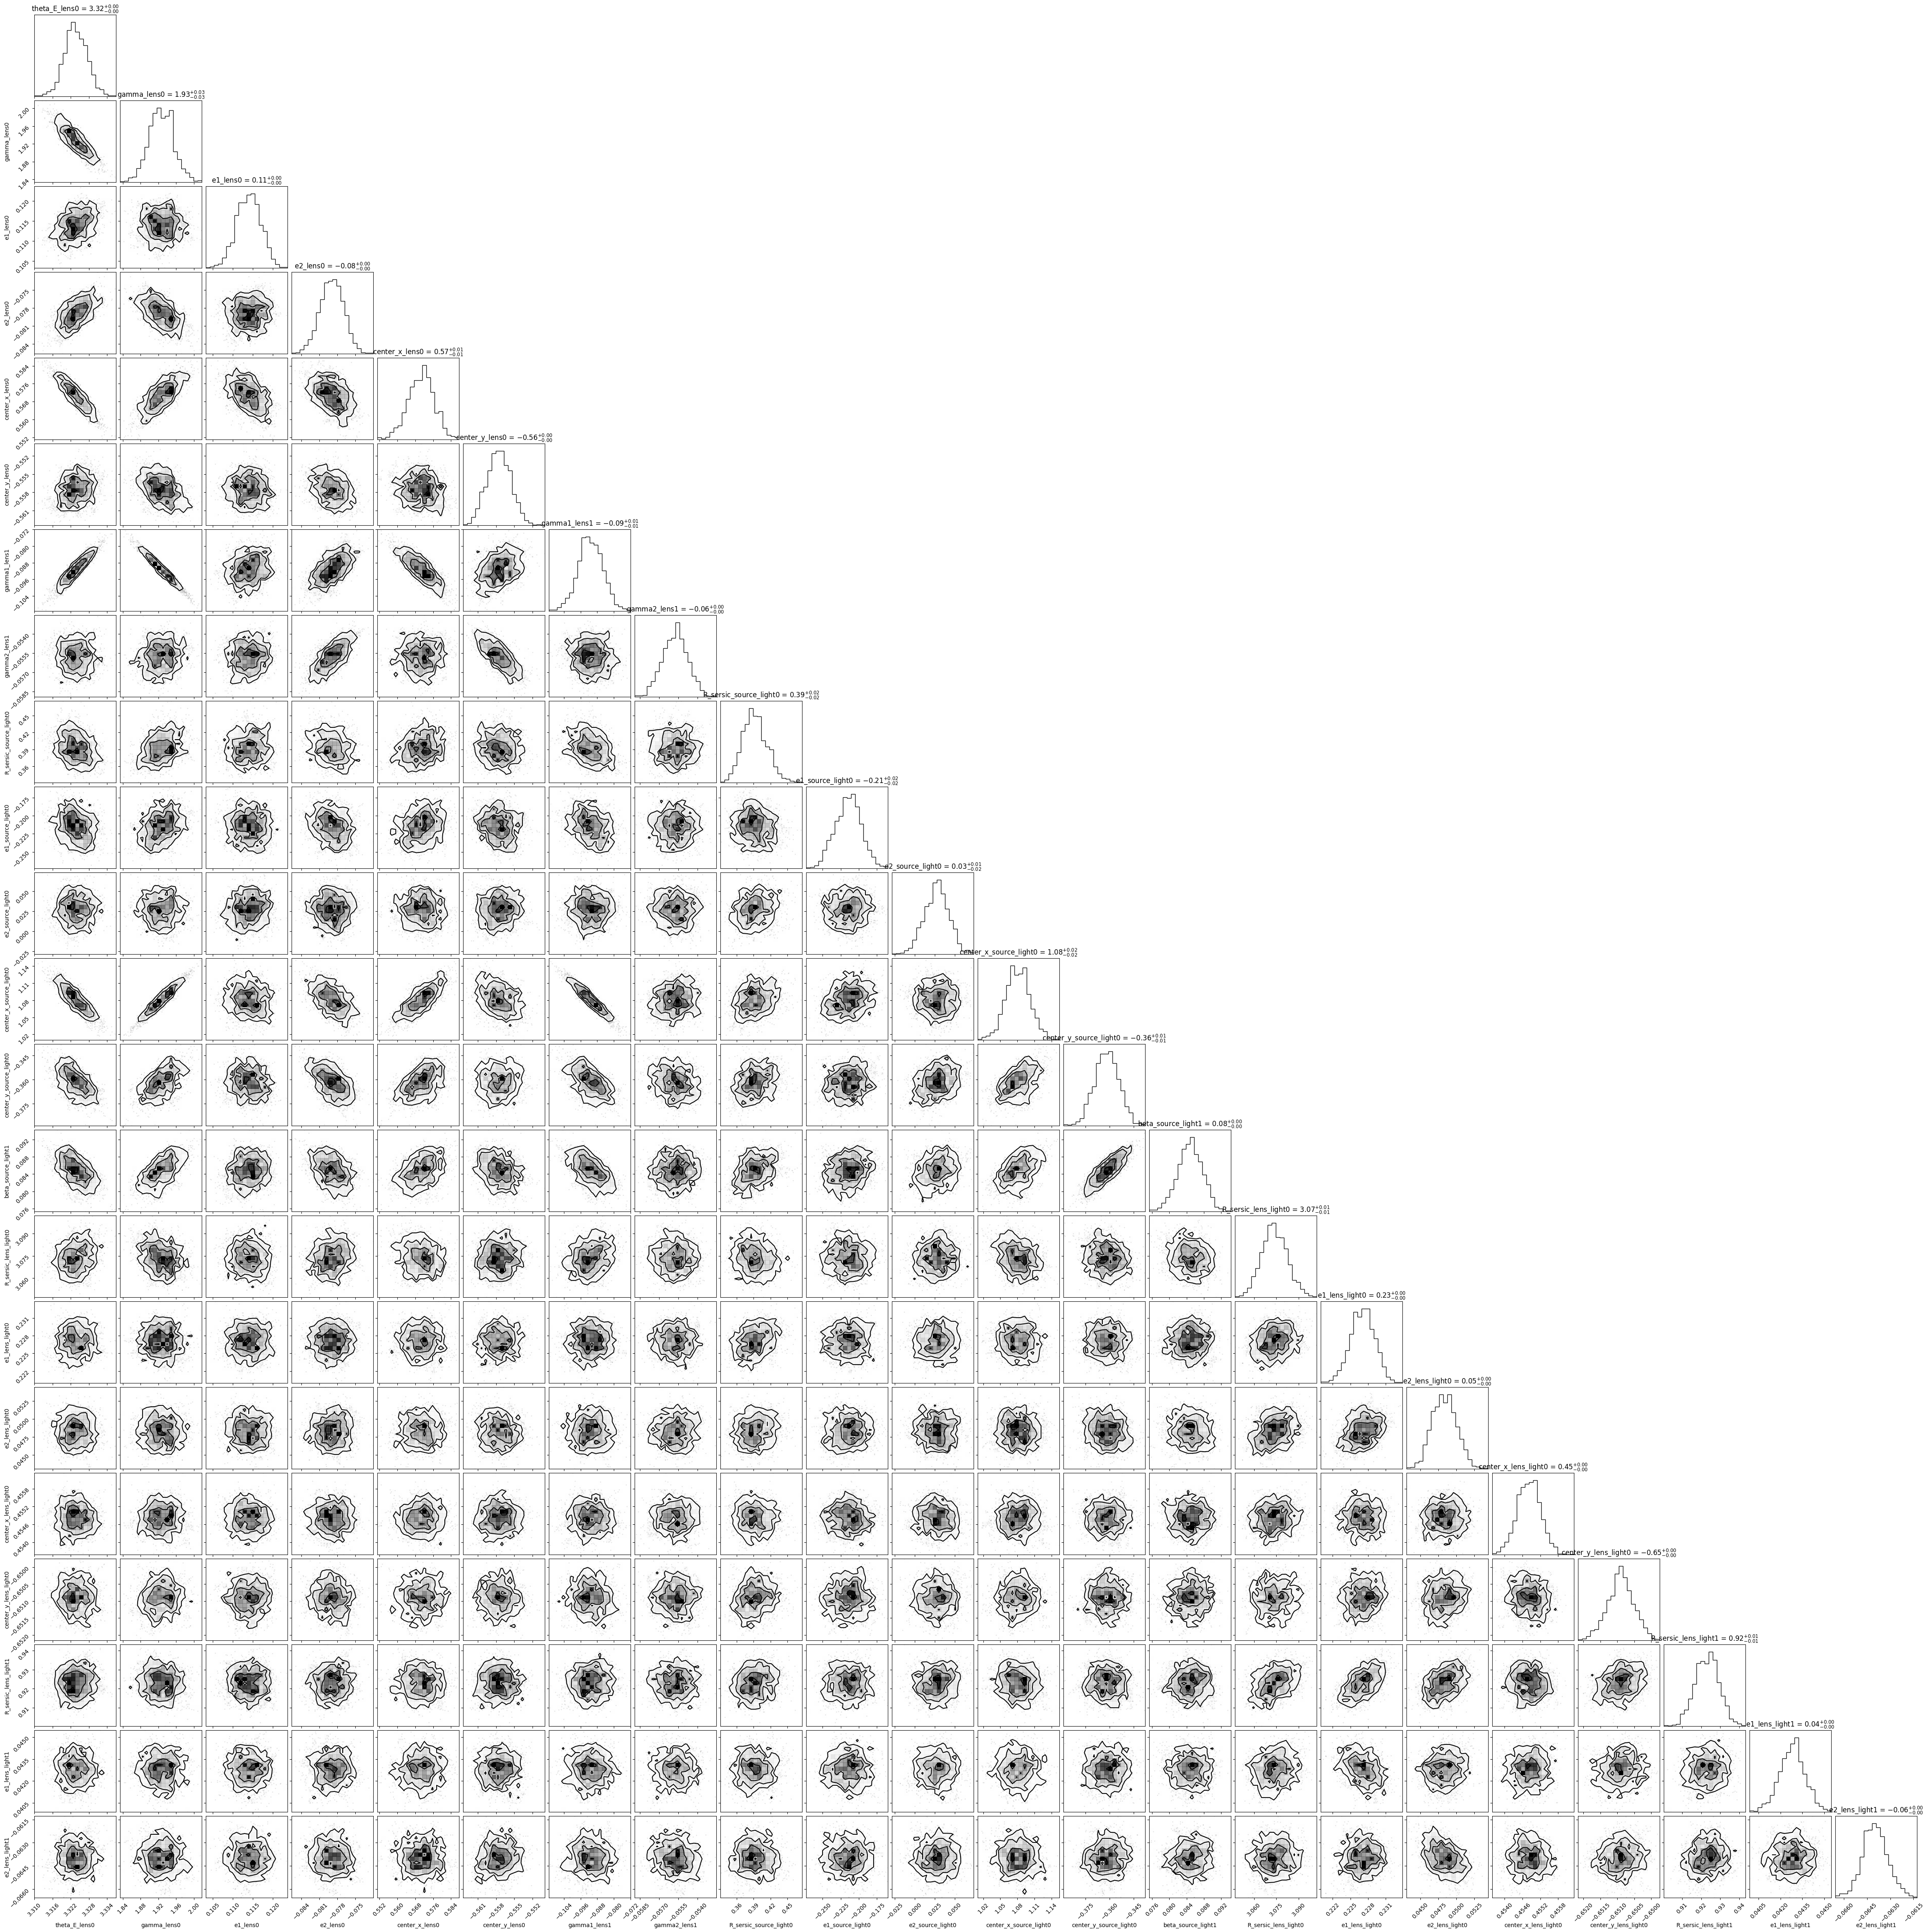

In [ ]:
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq_mcmc.param_class

    print("Number of non-linear parameters in the MCMC process:", 
          len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", 
              np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 2450
        thin = 20
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc,
                                show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")


## Visualizing the fitted model with `MCMC`

-0.9780014635474022 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9780014635474018


/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,


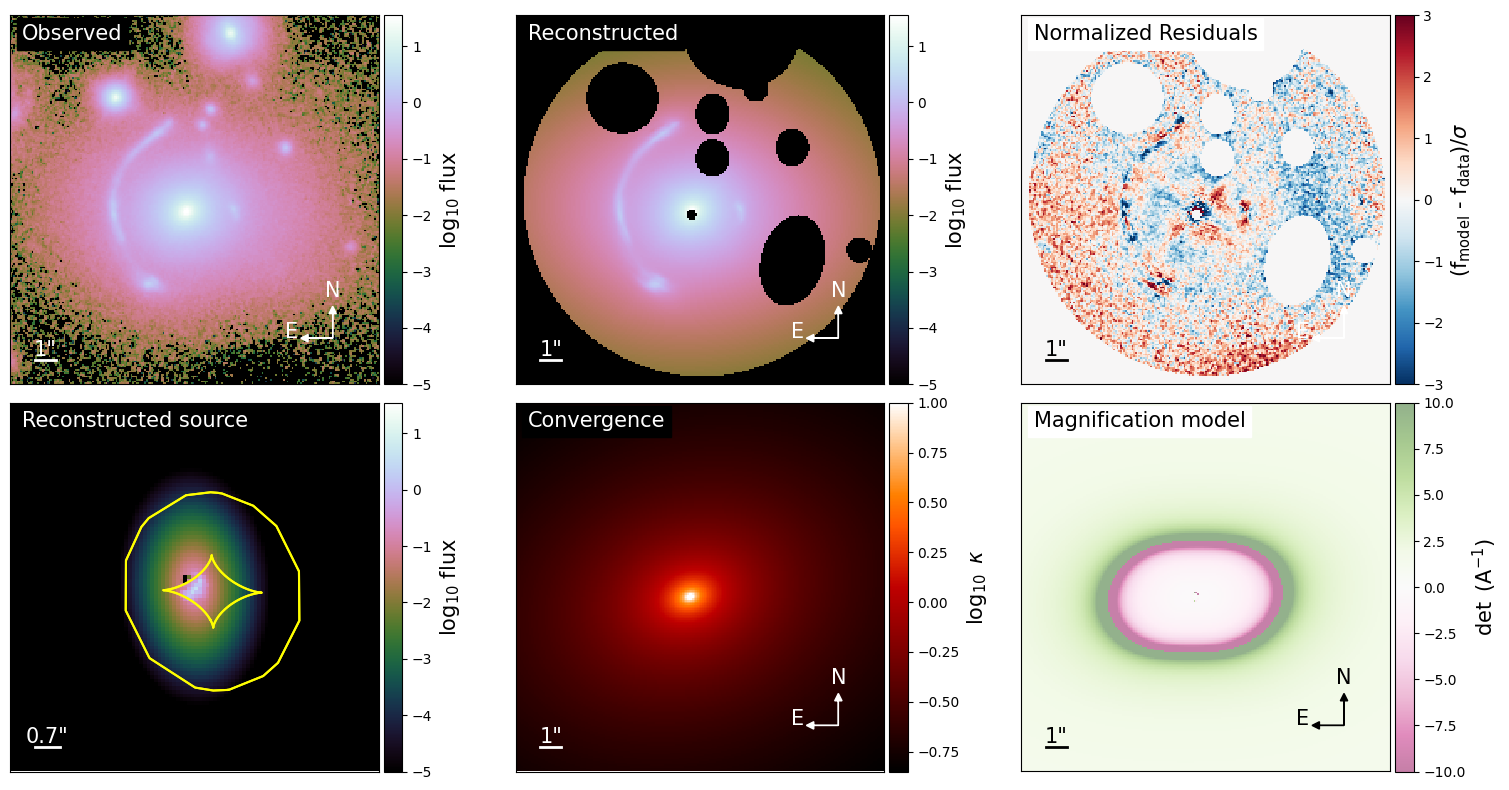

/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:511: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


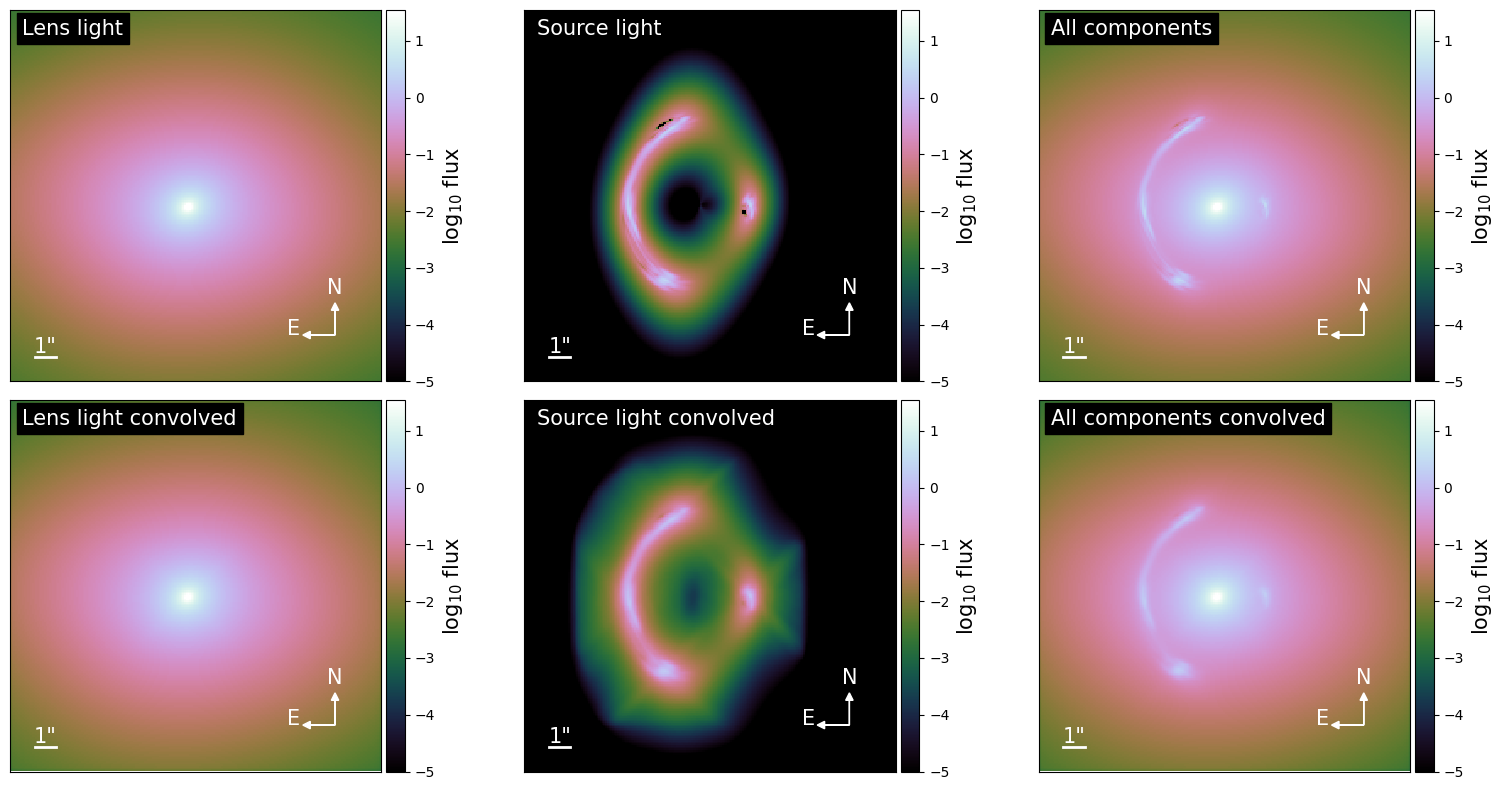

{'kwargs_lens': [{'theta_E': 3.3221667234990084, 'gamma': 1.9353645513272273, 'e1': 0.11250513098236911, 'e2': -0.0783218172631204, 'center_x': 0.5739065580403525, 'center_y': -0.559001992109333}, {'gamma1': -0.09342573713530916, 'gamma2': -0.055154632887366495, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 10.92199908738469, 'R_sersic': 0.3916961584953142, 'n_sersic': 1.0, 'e1': -0.21817798078275527, 'e2': 0.024046709293090305, 'center_x': 1.086975720186064, 'center_y': -0.3581975344524271}, {'amp': array([ 4.12267938e+02, -1.65259659e+02, -2.50830748e+02,  4.35386164e+01,
       -9.53296204e+01,  2.03450380e+02, -1.49718346e+01,  7.38439330e+01,
        3.76252973e+01, -4.53807777e+01,  2.94386680e+01, -5.66054034e+01,
        1.10488763e+02, -1.30692874e+02,  3.18640533e+01, -1.13247837e+01,
       -1.72490949e+01, -9.03218995e+01, -5.59247239e+01,  1.29147042e+01,
       -5.12759628e+01, -5.56947659e+00, -1.43840711e+00,  1.86690968e+01,
       -3.42779321e+01,  6.96708471e+01

In [ ]:
from lenstronomy.Plots.model_plot import ModelPlot

model_plot = ModelPlot(
    multi_band_list, kwargs_model, kwargs_result_mcmc, 
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"]
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3,
                                   cmap='RdBu_r')
model_plot.source_plot(ax=axes[1, 0], deltaPix_source=0.1, numPix=100, 
                       with_caustics=True, scale_size=0.7)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap='gist_heat')
model_plot.magnification_plot(ax=axes[1, 2], cmap='PiYG')

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, 
                  top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(ax=axes[0, 0], text='Lens light', 
                              lens_light_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1, 0], text='Lens light convolved', 
                              lens_light_add=True)
model_plot.decomposition_plot(ax=axes[0, 1], text='Source light', 
                              source_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1, 1], text='Source light convolved', 
                              source_add=True)
model_plot.decomposition_plot(ax=axes[0, 2], text='All components', 
                              source_add=True, lens_light_add=True, 
                              unconvolved=True)
model_plot.decomposition_plot(ax=axes[1, 2], text='All components convolved', 
                              source_add=True, lens_light_add=True, 
                              point_source_add=True)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, 
                  wspace=0., hspace=0.05)
plt.show()

print(kwargs_result_mcmc)

In [23]:
multi_band_list_out = fitting_seq_mcmc.multi_band_list
kwargs_fixed_out = fitting_seq_mcmc.kwargs_fixed

init_samples = 2890  # can be not `None` for MCMC

input = [fitting_kwargs_list_mcmc, multi_band_list, kwargs_model, 
         kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples]
output = [kwargs_result_mcmc, multi_band_list_out,
          kwargs_fixed_out]

output_path = './DESIJ2158+0257_mcmc_output.joblib'

with open(output_path, 'wb') as f:
    joblib.dump([input, output], f, compress=True)